### Chest X-Ray Images (Pneumonia) Detection Using Convolutional Neural Networks with pytorch


**Introduction:**

Image Classification is an approach that is being widely utilised for different purposes in the realm of medical imaging and diagnostics. Pneumonia, a potentially life-threatening respiratory infection, poses a significant global health challenge, and rapid and accurate diagnosis is paramount for effective treatment. In an era where healthcare technology is advancing at an unprecedented pace, the importance of this method can't be overstated.Convolutional Neural Networks (CNNs) have emerged as a powerful image classification tool in image analysis, which can also be utilised to detect Pneumonia in Chest X-Ray Images which provides the capabilities to healthcare professionals in identifying pneumonia in diverse clinical scenarios, from crowded emergency rooms to remote telemedicine consultations in real-time.



**Dataset:**

- The dataset is divided into three folders - 'train', 'test', and 'val', and it contains subfolders for different image categories, specifically 'Pneumonia' and 'Normal'. There are a total of 5,863 X-Ray images in JPEG format, falling into these two categories.

- These chest X-ray images were obtained from pediatric patients aged one to five years old. These images were collected at the Guangzhou Women and Children’s Medical Center in Guangzhou, China, as part of their routine clinical care.

- To ensure the quality of the chest X-ray images, they were initially screened to remove any low-quality or unreadable scans. After this, two expert physicians examined and graded the diagnoses before using them to train the AI system. To further ensure accuracy, a third expert checked the evaluation set to account for any grading errors in the diagnoses.

Link to the data card on Kaggle: [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data)

Link to second Dataset on Kaggle: [COVID-19_Radiography_Dataset](https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database)

Installing and Importing Dependencies

In [ ]:
!pip install kaggle torch torchvision

Downloading Data using Kaggle API directly to colab environment.

In [1]:
import os

# Specify the directory you want to check
directory = '../chest_xray/train/NORMAL'

# Count the number of files
file_count = len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])
print(f'There are {file_count} files in the directory.')


There are 4341 files in the directory.


In [2]:
# Specify the directory you want to check
directory = '../chest_xray/train/PNEUMONIA'

# Count the number of files
file_count = len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])
print(f'There are {file_count} files in the directory.')


There are 3875 files in the directory.


Importing Modules

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset, random_split, SubsetRandomSampler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import os
import json
import gc
import pathlib


/Users/ganeshghimire/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def calculate_transforms(data_dir):
    # Modify this line to ensure the dataset's transform converts images to tensors
    train_dataset = datasets.ImageFolder(data_dir+"train/", transform=transforms.ToTensor())
    first_train_image, _ = train_dataset[0]

    # Make sure first_train_image is a tensor before calling unsqueeze
    if isinstance(first_train_image, Image.Image):
        first_train_image = transforms.ToTensor()(first_train_image)

    first_train_image = first_train_image.unsqueeze(0)  # Add batch dimension
    grid_image = make_grid(first_train_image, normalize=True)  # Create a grid to get a single image

    # Compute mean and std for the first test image
    mean = grid_image.mean(dim=[1,2])
    std = grid_image.std(dim=[1,2])

    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomRotation(10),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomAffine(0, translate=(0.1, 0.1)),
            transforms.ColorJitter(brightness=(0.5, 1.5)), 
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(), std.tolist())
        ]),
        'val': transforms.Compose([
            transforms.Resize(size=(224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(), std.tolist())
        ]),
    }

    # Save the transform parameters to a json file for future use
    transform_parameters = {"mean": mean.tolist(), "std": std.tolist()}
    with open('transform_parameters.json', 'w') as f:
        json.dump(transform_parameters, f)

    return data_transforms


# def get_data_loaders(data_dir: str, data_transforms: dict, batch_size: int = 64):
#     # Loading the datasets with transformations
#     train_dataset = datasets.ImageFolder(data_dir+"train/", transform=data_transforms['train'])
#     test_dataset = datasets.ImageFolder(data_dir+"test/", transform=data_transforms['val'])
#     val_dataset = datasets.ImageFolder(data_dir+"val/", transform=data_transforms['val'])

#     # Data loaders
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

#     return train_dataset, test_dataset, val_dataset, train_loader, test_loader, val_loader

In [5]:
from torch.utils.data import random_split

def get_data_loaders(data_dir: str, data_transforms: dict, batch_size: int = 4):
    # Loading the datasets with transformations
    full_train_dataset = datasets.ImageFolder(data_dir+"train/", transform=data_transforms['train'])
    test_dataset = datasets.ImageFolder(data_dir+"test/", transform=data_transforms['val'])

    # Calculate the lengths for train and validation datasets (80-20 split)
    train_len = int(len(full_train_dataset) * 0.8)
    val_len = len(full_train_dataset) - train_len

    # Randomly split the full training dataset into training and validation datasets
    train_dataset, val_dataset = random_split(full_train_dataset, [train_len, val_len])

    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_dataset, test_dataset, val_dataset, train_loader, test_loader, val_loader


In [6]:
data_dir = "../chest_xray/"
data_transforms = calculate_transforms(data_dir)
train_dataset, test_dataset, val_dataset, train_loader, test_loader, val_loader = get_data_loaders(data_dir, data_transforms)

In [7]:
def count_different_image_types(path):
    subdirectories = [subdir.name for subdir in os.scandir(path) if subdir.is_dir()]
    num_image_types = len(subdirectories)
    print("Number of different types of images found:", num_image_types)
    print("Types of images detected:")
    for i, image_type in enumerate(subdirectories, start=1):
        print(f"{i}. {image_type}")

count_different_image_types('../chest_xray/train')
count_different_image_types('../chest_xray/test')
count_different_image_types('../chest_xray/val')

Number of different types of images found: 2
Types of images detected:
1. PNEUMONIA
2. NORMAL
Number of different types of images found: 2
Types of images detected:
1. PNEUMONIA
2. NORMAL
Number of different types of images found: 2
Types of images detected:
1. PNEUMONIA
2. NORMAL


In [8]:
# define functions for getting class distribution plots and sumary stats
def plot_class_distribution(data, data_name):
    class_names = ['NORMAL', 'PNEUMONIA']
    class_counts = torch.zeros(len(class_names))

    for _, y in data:
        class_counts[y] += 1

    plt.bar(class_names, class_counts)
    plt.xlabel("Class")
    plt.ylabel("Number of images")
    plt.title(f"Class distribution in the {data_name} dataset")
    plt.show()

def summary_stats(dataset):
    mean = torch.zeros(3)
    std = torch.zeros(3)

    for x, _ in dataset:
        mean += x.mean(dim=(1, 2))  # Compute mean along channels
        std += x.std(dim=(1, 2))  # Compute std along channels

    mean /= len(dataset)
    std /= len(dataset)

    return mean.tolist(), std.tolist()


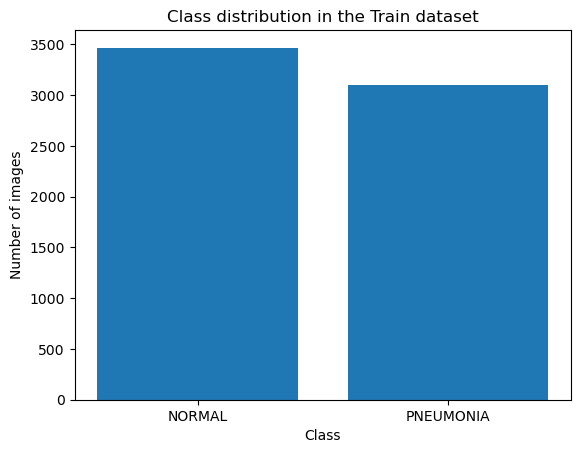

Train dataset mean: [-0.05036201700568199, -0.05036201700568199, -0.05036201700568199], standard deviation: [0.9471173882484436, 0.9471173882484436, 0.9471173882484436]


In [9]:
plot_class_distribution(train_dataset, "Train")
mean, std = summary_stats(train_dataset)
print(f"Train dataset mean: {mean}, standard deviation: {std}")

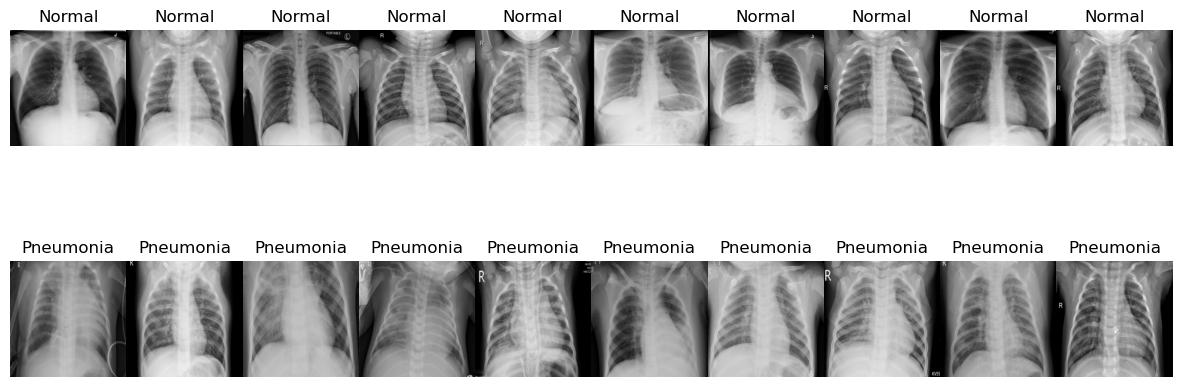

In [29]:
from torchvision.datasets import ImageFolder
transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
dataset = ImageFolder(root='../chest_xray/train', transform=transform)
loader = DataLoader(dataset, batch_size=20, shuffle=True)# Function to show images
def show_images(images, labels, n=10):
    plt.figure(figsize=(15, 6))  # Adjust figure size to fit one row of 10 images
    count_normal = count_pneumonia = 0

    for i, (img, label) in enumerate(zip(images, labels)):
        if label == 0 and count_normal < n:  # Normal images
            plt.subplot(2, n, count_normal + 1)
            count_normal += 1
        elif label == 1 and count_pneumonia < n:  # Pneumonia images
            plt.subplot(2, n, n + count_pneumonia + 1)
            count_pneumonia += 1
        plt.imshow(img.permute(1, 2, 0))
        plt.title("Pneumonia" if label == 1 else "Normal")
        plt.axis('off')

        if count_normal >= n and count_pneumonia >= n:
            break

    plt.subplots_adjust(wspace=0, hspace=0)  # Remove gaps between images
    plt.show()

# Get a batch of images and show them
for images, labels in loader:
    show_images(images, labels)
    break

In [10]:
def get_model(device):
    """
    Function to get the model.
    """
    class CNNModel(nn.Module):
        def __init__(self):
            super(CNNModel, self).__init__()
            self.conv1 = nn.Conv2d(3, 8, kernel_size=7, padding=3)
            self.conv2 = nn.Conv2d(8, 8, kernel_size=7, padding=3)
            self.pool1 = nn.MaxPool2d(kernel_size=3, stride=3)

            self.conv3 = nn.Conv2d(8, 16, kernel_size=5, padding=2)
            self.conv4 = nn.Conv2d(16, 16, kernel_size=5, padding=2)
            self.pool2 = nn.MaxPool2d(kernel_size=3, stride=3)

            self.conv5 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
            self.conv6 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

            self.conv7 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
            self.conv8 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

            self.conv9 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
            self.conv10 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
            self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

            self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))
            self.flatten = nn.Flatten()
            self.fc1 = nn.Linear(128*7*7, 128)
            self.dropout = nn.Dropout(0.2)
            self.fc2 = nn.Linear(128, 2)

        def forward(self, x):
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = self.pool1(x)

            x = F.relu(self.conv3(x))
            x = F.relu(self.conv4(x))
            x = self.pool2(x)

            x = F.relu(self.conv5(x))
            x = F.relu(self.conv6(x))
            x = self.pool3(x)

            x = F.relu(self.conv7(x))
            x = F.relu(self.conv8(x))
            x = self.pool4(x)

            x = F.relu(self.conv9(x))
            x = F.relu(self.conv10(x))
            x = self.pool5(x)

            x = self.adaptive_pool(x)
            x = self.flatten(x)
            x = F.relu(self.fc1(x))
            x = self.dropout(x)
            x = self.fc2(x)
            return x

    model = CNNModel().to(device)
    return model

In [11]:

def train_model(model, train_loader, val_loader, device, num_epochs=10, learning_rate=0.0001):
    """
    Function to train the model.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_val_loss = float("inf")
    train_loss_history, val_loss_history = [], []
    train_accuracy_history, val_accuracy_history = [], []

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        train_loss = running_loss / len(train_loader)
        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)

        # Validation
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_loss = running_loss / len(val_loader)
        val_loss_history.append(val_loss)
        val_accuracy_history.append(val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

        # Create a directory if not exists
        saved_models_dir = 'saved_models'
        if not os.path.exists(saved_models_dir):
            os.makedirs(saved_models_dir)

        # Save the model if it has the best validation loss so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_path = os.path.join(saved_models_dir, 'best_model.pth')
            torch.save(model.state_dict(), best_model_path)
            print('Model checkpoint saved at {}'.format(best_model_path))

    return model, train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history


In [12]:
def evaluate_model(model, test_loader, device, class_names):
    """
    Function to evaluate the model.
    """
    model.eval()
    correct, total = 0, 0
    true_labels, pred_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total

    # Classification report
    print('Classification Report:')
    print(classification_report(true_labels, pred_labels, target_names=class_names))

    # Confusion matrix
    conf_matrix = confusion_matrix(true_labels, pred_labels)
    df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
    plt.figure(figsize=(5,5))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig("confusion_matrix.png")
    plt.show()

    return accuracy, true_labels, pred_labels

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = "../chest_xray/"
num_epochs = 10
batch_size = 4

In [14]:
class_names = ['NORMAL', 'PNEUMONIA']

In [15]:
# import torch
# import gc

# # 1. Delete the prvious model model
# del model

# # 2. Empty the cache from CUDA
# torch.cuda.empty_cache()

# # 3. Use Python's garbage collector
# gc.collect()

In [16]:
model = get_model(device)

In [17]:
model, train_loss, train_acc, val_loss, val_acc = train_model(model, train_loader, val_loader, device, num_epochs)

Epoch 1/10, Train Loss: 0.5715, Train Acc: 69.58%, Val Loss: 0.4869, Val Acc: 74.82%
Model checkpoint saved at saved_models/best_model.pth
Epoch 2/10, Train Loss: 0.4615, Train Acc: 76.90%, Val Loss: 0.4204, Val Acc: 80.29%
Model checkpoint saved at saved_models/best_model.pth
Epoch 3/10, Train Loss: 0.4176, Train Acc: 80.43%, Val Loss: 0.4064, Val Acc: 81.02%
Model checkpoint saved at saved_models/best_model.pth
Epoch 4/10, Train Loss: 0.4027, Train Acc: 81.53%, Val Loss: 0.4160, Val Acc: 80.72%
Epoch 5/10, Train Loss: 0.3834, Train Acc: 82.27%, Val Loss: 0.3348, Val Acc: 84.37%
Model checkpoint saved at saved_models/best_model.pth
Epoch 6/10, Train Loss: 0.3611, Train Acc: 83.70%, Val Loss: 0.3387, Val Acc: 84.67%
Epoch 7/10, Train Loss: 0.3581, Train Acc: 84.39%, Val Loss: 0.3158, Val Acc: 86.01%
Model checkpoint saved at saved_models/best_model.pth
Epoch 8/10, Train Loss: 0.3397, Train Acc: 85.04%, Val Loss: 0.3046, Val Acc: 86.25%
Model checkpoint saved at saved_models/best_model.

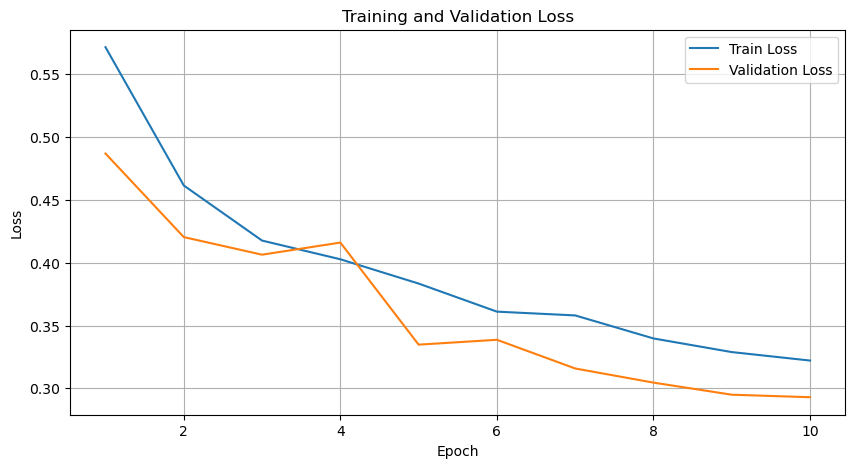

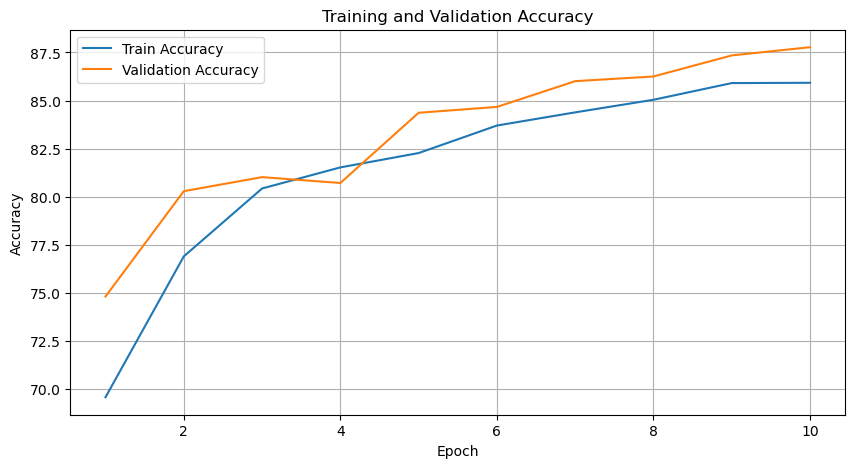

In [18]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig("validation_train loss.png")
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_acc, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)
plt.savefig("validation_train accuracy.png")
plt.show()

In [23]:
checkpoint_path = 'saved_models/best_model.pth'
# Load the best model checkpoint
best_model = get_model(device)
best_model.load_state_dict(torch.load(checkpoint_path))

<All keys matched successfully>

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.66      0.94      0.78       234
   PNEUMONIA       0.96      0.71      0.81       390

    accuracy                           0.80       624
   macro avg       0.81      0.83      0.79       624
weighted avg       0.84      0.80      0.80       624



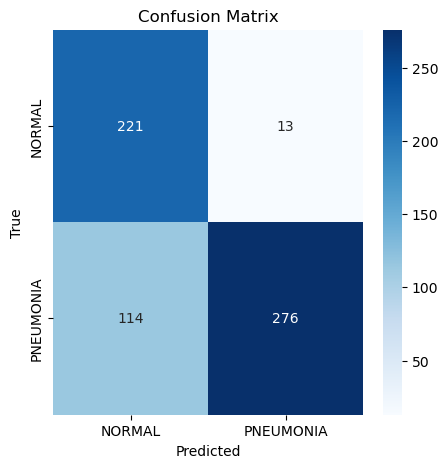

Test Accuracy: 79.6474358974359%


In [24]:
accuracy, true_labels, pred_labels = evaluate_model(best_model, test_loader, device, class_names)
print(f'Test Accuracy: {accuracy}%')

# **To run Streamlit App in Colab** Run below cells.

In [ ]:
# !pip install -q streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.7 MB/s eta 0:00:00


In [ ]:
# %%writefile app.py
# import streamlit as st
# import torch
# from PIL import Image
# import json
# import matplotlib.pyplot as plt
# from torchvision import transforms
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# from torch.utils.data import DataLoader, ConcatDataset, random_split, SubsetRandomSampler
# import torchvision.datasets as datasets
# import torchvision.transforms as transforms
# from torchvision.utils import make_grid
# from sklearn.metrics import classification_report, confusion_matrix
# import numpy as np
# import pandas as pd
# # import other necessary modules

# def get_model(device):
#     """
#     Function to get the model.
#     """
#     class CNN(nn.Module):
#         def __init__(self):
#             super(CNN, self).__init__()
#             self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
#             self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
#             self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
#             self.pool = nn.MaxPool2d(2, 2)
#             self.fc1 = nn.Linear(64 * 7 * 7, 512)
#             self.fc2 = nn.Linear(512, 2)
#             self.dropout = nn.Dropout(0.5)

#         def forward(self, x):
#             x = self.pool(F.relu(self.conv1(x)))
#             x = self.pool(F.relu(self.conv2(x)))
#             x = self.pool(F.relu(self.conv3(x)))
#             x = x.view(-1, 64 * 7 * 7)
#             x = F.relu(self.fc1(x))
#             x = self.dropout(x)
#             x = self.fc2(x)
#             return x

#     model = CNN().to(device)
#     return model

# # Load your trained model
# def load_model(model_path):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model = get_model(device)  # your get_model function
#     model.load_state_dict(torch.load(model_path, map_location=device))
#     model.eval()
#     return model

# # Function to process an uploaded image
# def process_image(uploaded_file):
#     # Open the image file
#     img = Image.open(uploaded_file)

#     # Convert grayscale or images with alpha channel to RGB
#     if img.mode != 'RGB':
#         img = img.convert('RGB')
#     # You should load your saved transforms from 'transform_parameters.json'
#     with open('transform_parameters.json') as f:
#         transform_parameters = json.load(f)
#     mean = transform_parameters['mean']
#     std = transform_parameters['std']
#     transform = transforms.Compose([
#         transforms.Resize(size=(56, 56)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=mean, std=std)
#     ])
#     return transform(img).unsqueeze(0)  # Add batch dimension

# # Function to get predictions
# def predict(model, image):
#     # Check the device the model is on
#     device = next(model.parameters()).device
#     # Move the image tensor to the device the model is on
#     image = image.to(device)
#     outputs = model(image)
#     # Calculate probabilities
#     probs = torch.nn.functional.softmax(outputs, dim=1)
#     highest_prob, predicted = torch.max(probs, 1)
#     return highest_prob, predicted

# def plot_image(image_path, caption):
#     """
#     Function to display an image with a caption
#     """
#     image = Image.open(image_path)
#     st.image(image, caption=caption, use_column_width=True)

# def main():
#     st.title("Pneumonia Detection from Chest X-Ray Images")

#     # Create a mapping for classes
#     class_names = {0: 'Normal', 1: 'Pneumonia'}

#     # Load the model
#     model = load_model('/content/saved_models/best_model.pth')  # update the path

#     # Upload image and preprocess it
#     uploaded_file = st.file_uploader("Choose a chest X-ray image...", type=["jpg", "png", "jpeg"])
#     if uploaded_file is not None:
#         st.image(uploaded_file, caption='Uploaded Chest X-Ray.', use_column_width=True)
#         if st.button('Predict'):
#             image = process_image(uploaded_file)
#             highest_prob, predicted = predict(model, image)
#             predicted_class = class_names[predicted.item()]
#             # Use markdown to display results in a larger font
#             st.markdown(f"<h2 style='text-align: center; color: red;'>Prediction: {predicted_class}</h2>", unsafe_allow_html=True)
#             st.markdown(f"<h3 style='text-align: center; color: white;'>Probability: {highest_prob.item()*100:.2f}%</h3>", unsafe_allow_html=True)

#     # Adding another page in the app for model details
#     page = st.sidebar.selectbox("Choose a page", ["Prediction", "Model Details"])

#     if page == "Model Details":
#         st.header("Model Details")

#         # Model Introduction
#         st.subheader("Introduction:")
#         st.write("""
#         Image Classification is an approach that is being widely utilised for different purposes in the realm of medical imaging and diagnostics. Pneumonia, a potentially life-threatening respiratory infection, poses a significant global health challenge, and rapid and accurate diagnosis is paramount for effective treatment.
#         """)

#         # Dataset details
#         st.subheader("Dataset:")
#         st.write("""
#         - The dataset is divided into three folders - 'train', 'test', and 'val', and it contains subfolders for different image categories, specifically 'Pneumonia' and 'Normal'.
#         - These chest X-ray images were obtained from pediatric patients aged one to five years old.
#         """)
#         st.markdown("[Link to the dataset on Kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data)")

#         # Display the images: Confusion Matrix, Validation-Train Accuracy and Validation-Train Loss
#         plot_image("confusion_matrix.png", "Confusion Matrix")


#         # Classification Report
#         st.subheader("Classification Report:")
#         st.write("""
#         ```
#         Classification Report:
#                    precision    recall  f1-score   support
#               Normal       0.73      0.87      0.79       234
#            Pneumonia       0.91      0.80      0.85       390
#             accuracy                           0.83       624
#            macro avg       0.82      0.84      0.82       624
#         weighted avg       0.84      0.83      0.83       624
#         ```
#         """)

#         # Model Architecture
#         st.subheader("Model Architecture:")
#         st.write("""
#         The Convolutional Neural Network (CNN) architecture consists of four convolutional layers followed by pooling layers. After the convolutional layers, there are three fully connected layers with a dropout layer in between to prevent overfitting. The model outputs two classes: 'Normal' and 'Pneumonia'. This architecture was trained using a batch size of 64, learning rate of 0.001, and for a total of 12 epochs. The training and validation accuracy achieved is displayed in the provided plots.
#         """)
#         plot_image("validation_train accuracy.png", "Validation-Train Accuracy")
#         plot_image("validation_train loss.png", "Validation-Train Loss")

# # The main entry of the application
# if __name__ == "__main__":
#     main()

Overwriting app.py


In [ ]:
# !npm install localtunnel

npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm notice created a lockfile as package-lock.json. You should commit this file.
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ localtunnel@2.0.2
added 22 packages from 22 contributors and audited 22 packages in 1.374s

3 packages are looking for funding
  run `npm fund` for details

found 0 vulnerabilities



In [ ]:
# !streamlit run app.py &>/content/logs.txt &

In [ ]:
# !npx localtunnel --port 8501 & curl ipv4.icanhazip.com

34.34.1.14
npx: installed 22 in 1.978s
your url is: https://dark-trams-count.loca.lt
